In [1]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from IPython.display import display, IFrame, HTML
from ae483tools import *
from scipy import linalg

In [2]:
mocap_color = 'C0'
mocap_linestyle = '-'
mocap_linewidth = 2

default_color = 'C1'
default_linestyle = '--'
default_linewidth = 2

desired_color = 'C2'
desired_linestyle = ':'
desired_linewidth = 4

custom_color = 'C3'
custom_linestyle = '-.'
custom_linewidth = 3

Load flight data.

In [6]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('hover_01.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'], False)

# Only look at data from the middle 10 seconds of when the drone was actually flying
only_in_flight(data_drone, data_mocap=data_mocap, t_interval=10.)

Parse flight data:
* Estimates from the custom observer implemented online are labled `_custom`.
* Estimates from the default observer are labeled `_default`.

In [7]:
# time
t = data_drone['time']

# position and orientation from custom observer
p_x_custom = data_drone['ae483log.p_x']
p_y_custom = data_drone['ae483log.p_y']
p_z_custom = data_drone['ae483log.p_z']
psi_custom = data_drone['ae483log.psi']
theta_custom = data_drone['ae483log.theta']
phi_custom = data_drone['ae483log.phi']

# position and orientation from default observer
p_x_default = data_drone['stateEstimate.x']
p_y_default = data_drone['stateEstimate.y']
p_z_default = data_drone['stateEstimate.z']
psi_default = np.deg2rad(data_drone['stateEstimate.yaw'])
theta_default = - np.deg2rad(data_drone['stateEstimate.pitch'])
phi_default = np.deg2rad(data_drone['stateEstimate.roll'])

# position and orientation from the motion capture system
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']

# desired position
p_x_des = data_drone['ae483log.p_x_des']
p_y_des = data_drone['ae483log.p_y_des']
p_z_des = data_drone['ae483log.p_z_des']

Plot position, desired position, and orientation.

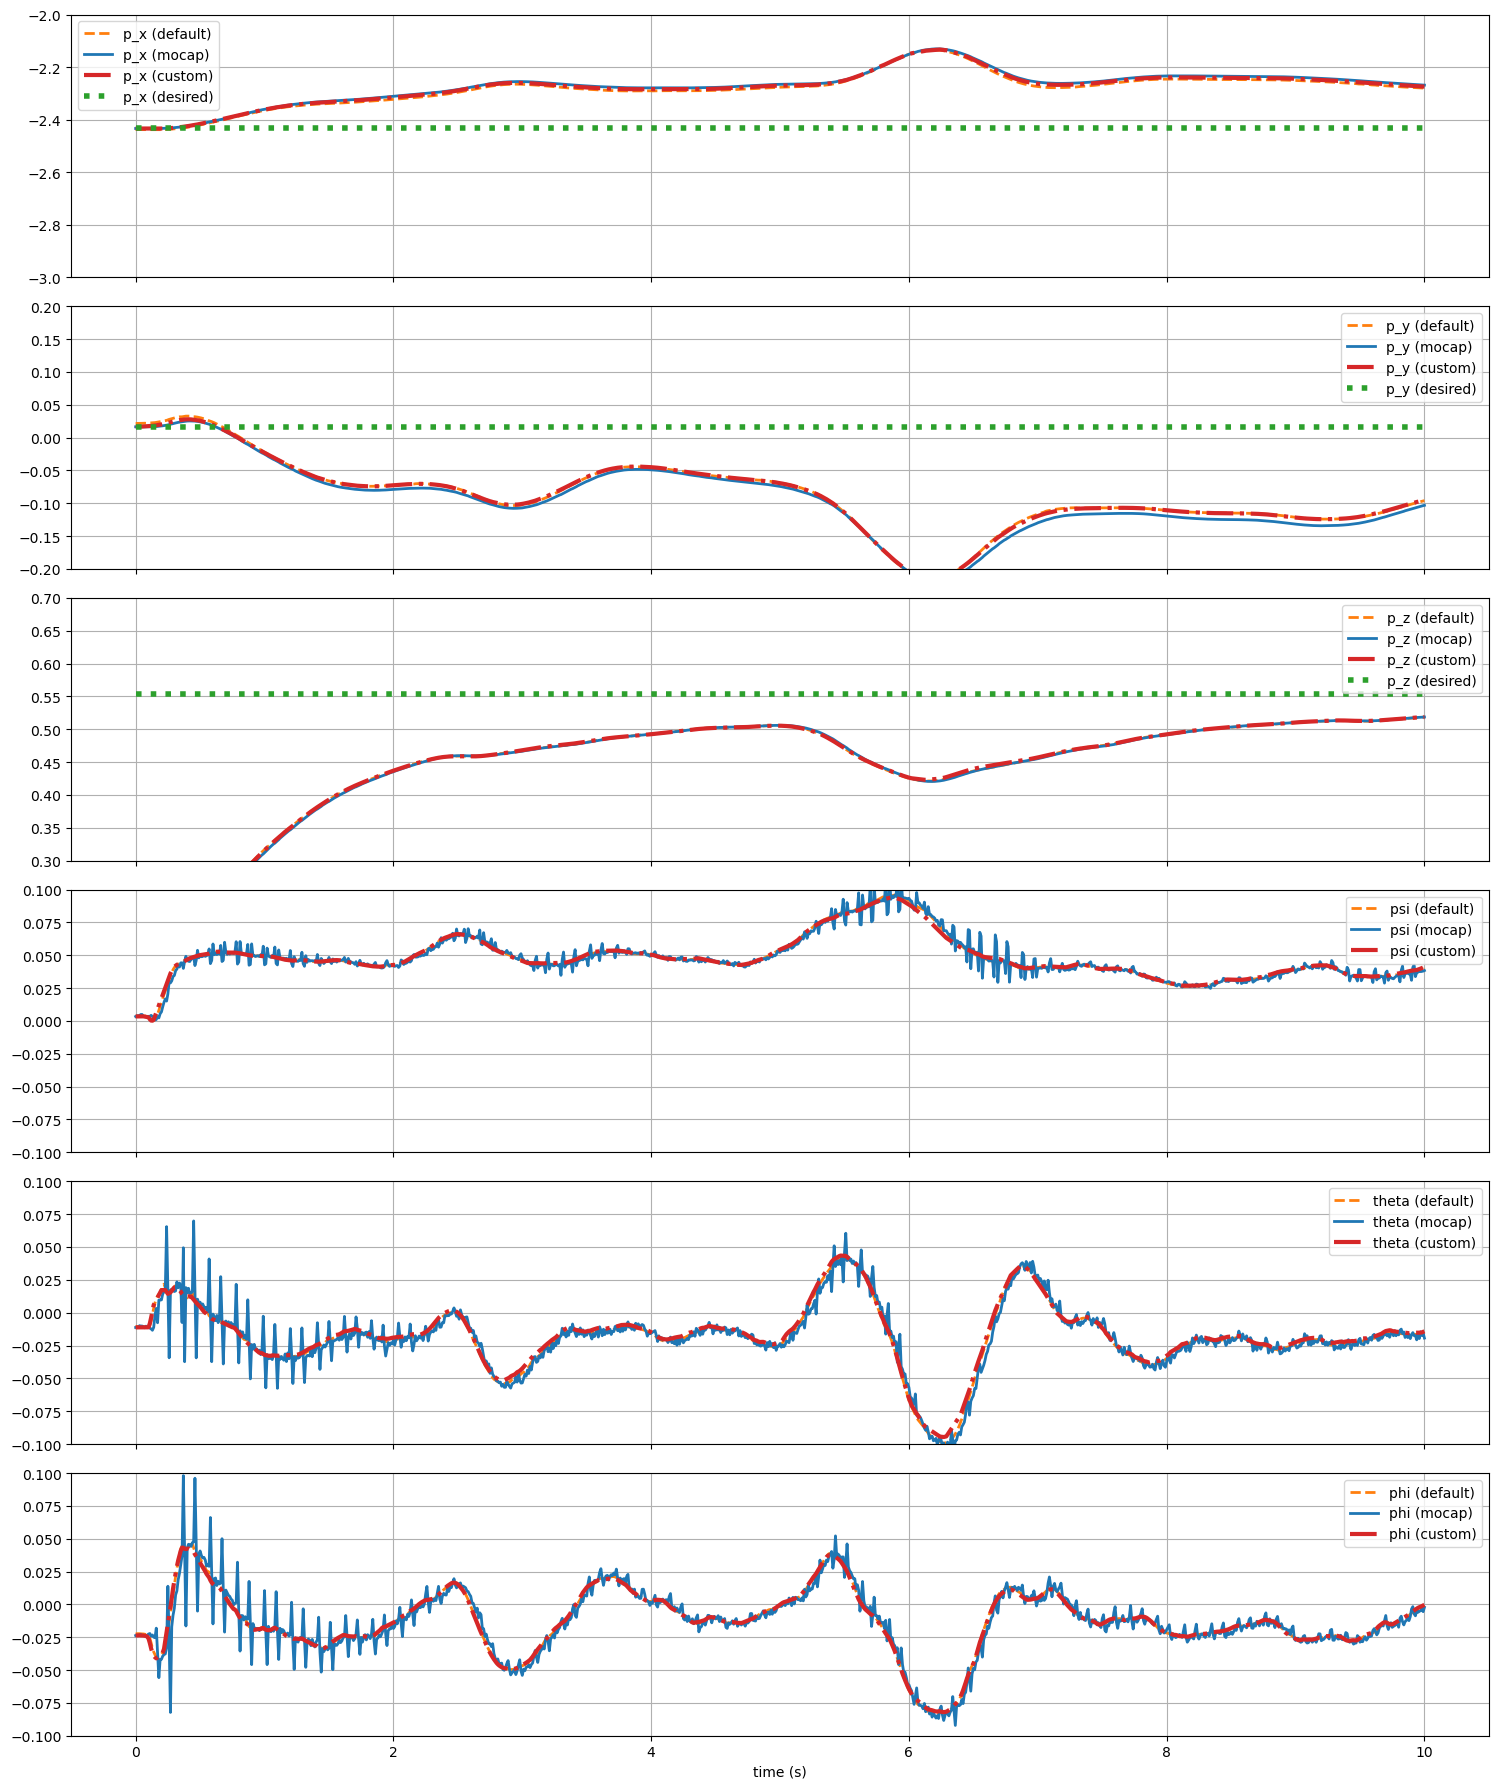

In [8]:
def comparison_plot(t, s_custom, s_default, s_mocap, name, ax, s_des=None):
    ax.plot(t, s_default, label=f'{name} (default)',
            color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
    ax.plot(t, s_mocap, label=f'{name} (mocap)',
            color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
    ax.plot(t, s_custom, label=f'{name} (custom)',
            color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
    if s_des is not None:
        ax.plot(t, s_des, label=f'{name} (desired)',
                color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi) = plt.subplots(6, 1, figsize=(15, 18), sharex=True, tight_layout=True)
comparison_plot(t, p_x_custom, p_x_default, p_x_mocap, 'p_x', ax_p_x, s_des=p_x_des)
comparison_plot(t, p_y_custom, p_y_default, p_y_mocap, 'p_y', ax_p_y, s_des=p_y_des)
comparison_plot(t, p_z_custom, p_z_default, p_z_mocap, 'p_z', ax_p_z, s_des=p_z_des)
comparison_plot(t, psi_custom, psi_default, psi_mocap, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_mocap, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_mocap, 'phi', ax_phi)
ax_phi.set_xlabel('time (s)')
ax_p_x.set_ylim([-3, -2])
ax_p_y.set_ylim([-0.2, 0.2])
ax_p_z.set_ylim([0.3, 0.7])
ax_psi.set_ylim([-0.1, 0.1])
ax_theta.set_ylim([-0.1, 0.1])
ax_phi.set_ylim([-0.1, 0.1])
plt.show()